In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import altair as alt
alt.data_transformers.enable('data_server')
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

import math

### Import Data

In [6]:
df = pd.read_csv("application_record.csv")
credit_df = pd.read_csv("credit_record.csv")

From our vintage analysis, we define our final "bad" definition as an account that exceeds 90 days past due in the first 18 months of account opening

In [7]:
creditdfc = credit_df.copy()

# Map bad values to the STATUS column
statmap = {
    "0":0,
    "1":0,
    "2":1,
    "3":1,
    "4":1,
    "5":1,
    "C":0,
    "X":0
}

creditdfc["STATUS"] = creditdfc["STATUS"].map(statmap)

# Create a column containing opening month of each account
mapdict = {}
for id, data in creditdfc.groupby("ID"):
    start_month = data["MONTHS_BALANCE"].min()
    mapdict[id] = start_month

# Map "bad" state to the STATUS column
creditdfc["acct_open_month"] = creditdfc["ID"].map(mapdict)

# Calculate the months since the account was opened
creditdfc["months_since_open"] = creditdfc["MONTHS_BALANCE"] - creditdfc["acct_open_month"]

creditdfc = creditdfc[creditdfc["months_since_open"] <= 18]
creditdfcgrouped = creditdfc.groupby("ID")["STATUS"].sum().reset_index()
creditdfcgrouped["bad"] = np.where(creditdfcgrouped["STATUS"] > 0, 1, 0)
creditdfcgrouped.drop("STATUS", axis = 1, inplace = True)
df = df.merge(creditdfcgrouped, on = "ID", how = "left")
df["bad"] = df["bad"].fillna(0)

Lets see the bad rate in our portfolio:

In [8]:
df["bad"].sum()/df["bad"].count()

0.0012130692247529968

### Preprocessing

Now we pre-process our predictors

In [9]:
# Remove ID Field
if "ID" in df.columns:
    df = df.drop("ID", axis = 1)

# Improve human readability of certain fields
df["YEARS_BIRTH"] = round(abs(df["DAYS_BIRTH"])/365, 2)
df["DAYS_EMPLOYED"] = df["DAYS_EMPLOYED"].apply(lambda x: 0 if x > 0 else x)
df["YEARS_EMPLOYED"] = round(df["DAYS_EMPLOYED"]/-365, 2)
df["OCCUPATION_TYPE"] = df["OCCUPATION_TYPE"].fillna("Misc")

df.drop(["DAYS_BIRTH", "DAYS_EMPLOYED"], axis = 1, inplace = True)

# Map numeric columns with two or less unique values 
for column in df.select_dtypes("int64").columns:
    valuelen = len(df[column].value_counts().index)
    if valuelen == 1:
        df = df.drop(column, axis = 1)

for column in ["FLAG_WORK_PHONE", "FLAG_PHONE",	"FLAG_EMAIL"]:
    df[column] = df[column].map({1: "Y", 0: "N"})

df.head()
    


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,bad,YEARS_BIRTH,YEARS_EMPLOYED
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,Y,N,N,Misc,2.0,0.0,32.89,12.44
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,Y,N,N,Misc,2.0,0.0,32.89,12.44
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,N,N,N,Security staff,2.0,0.0,58.83,3.11
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,N,Y,Y,Sales staff,1.0,0.0,52.36,8.36
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,N,Y,Y,Sales staff,1.0,0.0,52.36,8.36


### Removing Outliers

In [10]:
boxplot1 = alt.Chart(df).mark_boxplot().encode(
    x = alt.X("CNT_CHILDREN")
)

boxplot2 = alt.Chart(df).mark_boxplot().encode(
    x = alt.X("AMT_INCOME_TOTAL")
)

boxplot3 = alt.Chart(df).mark_boxplot().encode(
    x = alt.X("CNT_FAM_MEMBERS")
)

alt.vconcat(boxplot1, boxplot2, boxplot3)

alt.VConcatChart(...)

In [11]:
df[["CNT_CHILDREN", "AMT_INCOME_TOTAL", "CNT_FAM_MEMBERS"]].describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS
count,438557.000000,4.385570e+05,438557.000000
mean,0.427390,1.875243e+05,2.194465
std,0.724882,1.100869e+05,0.897207
min,0.000000,2.610000e+04,1.000000
25%,0.000000,1.215000e+05,2.000000
50%,0.000000,1.607805e+05,2.000000
75%,1.000000,2.250000e+05,3.000000
max,19.000000,6.750000e+06,20.000000


In [12]:
df = df[(df["CNT_CHILDREN"] <= 4) & (df["AMT_INCOME_TOTAL"] < 1000000) & (df["CNT_FAM_MEMBERS"] <= 4)]
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,bad,YEARS_BIRTH,YEARS_EMPLOYED
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,Y,N,N,Misc,2.0,0.0,32.89,12.44
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,Y,N,N,Misc,2.0,0.0,32.89,12.44
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,N,N,N,Security staff,2.0,0.0,58.83,3.11
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,N,Y,Y,Sales staff,1.0,0.0,52.36,8.36
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,N,Y,Y,Sales staff,1.0,0.0,52.36,8.36


### Resample the data to include more rejected cases

### Transform Columns

Apply standardscaler to numeric columns, one-hot encoding for binary columns, ordinal encoding for categorical columns

In [13]:
from sklearn.compose import make_column_transformer
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

xdf = df.drop('bad', axis = 1)
ydf = df["bad"]

numeric_feats = list(xdf.select_dtypes(include = numerics).columns)
ord_feats = ["NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE"]
cat_feats = ["NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE"]
bin_feats = [x for x in xdf.columns if x not in numeric_feats + cat_feats + ord_feats]
income_types = ['Student', 'Pensioner', 'Working', 'Commercial associate', 'State servant']
education_types = ['Lower secondary', 'Secondary / secondary special', 'Incomplete higher', 'Higher education', 'Academic degree']

ct = make_column_transformer(
    (StandardScaler(), numeric_feats),
    # (OrdinalEncoder(categories=[income_types, education_types], dtype=int), ord_feats),
    (OneHotEncoder(sparse_output=False, dtype = "int"), cat_feats),
    (OneHotEncoder(drop="if_binary"), bin_feats)
)

X_transformed = ct.fit_transform(xdf)

In [14]:
xtrain, xtest, ytrain, ytest = train_test_split(
    X_transformed, ydf, test_size=0.2, random_state=123
)


In [15]:
oversample = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', oversample), ('u', under)]
pipeline = imbpipeline(steps=steps)

xtrain, ytrain = pipeline.fit_resample(xtrain, ytrain)

In [55]:
dummy = DummyClassifier()
dummy.fit(xtrain, ytrain)
dummy.score(xtrain, ytrain)

0.5

In [1]:
from sklearn.svm import SVC
svm = SVC(gamma=1, kernel = "rbf")  # Ignore gamma for now
svm.fit(xtrain, ytrain)
svm.score(xtest, ytest)
# scores = cross_validate(svm, xtrain, ytrain, return_train_score=True)
# print("Mean validation score %0.3f" % (np.mean(scores["test_score"])))
# pd.DataFrame(scores)

# results_df = pd.DataFrame(scores_dict)
# results_df

NameError: name 'xtrain' is not defined

In [84]:
def rocres_curve(model, ytest, xtest):
    y_scores = model.predict_proba(xtest)
    fpr, tpr, threshold = roc_curve(ytest, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of kNN')
    plt.show()

    return roc_auc

Text(0, 0.5, 'Cross-Validated Accuracy')

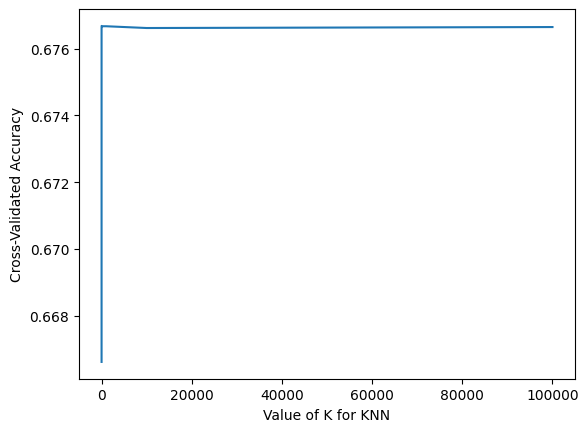

In [17]:

lr = LogisticRegression(max_iter = 1000000)

k_range = list(10.0 ** np.arange(-4, 6, 1))
parameters = {'C': k_range}
grid_lr = GridSearchCV(lr, parameters, cv=5, scoring='accuracy', return_train_score=False)
grid_lr.fit(xtrain, ytrain)

grid_mean_scoresLR = grid_lr.cv_results_['mean_test_score']

plt.plot(k_range, grid_mean_scoresLR)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [18]:
grid_mean_scoresLR

array([0.66661843, 0.66896276, 0.67426884, 0.67568702, 0.67659869,
       0.6766807 , 0.67667105, 0.67667105, 0.67661799, 0.67664693])

In [19]:
k_range

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

In [86]:
lr = LogisticRegression(C = 0.01, max_iter = 1000000)
lr.fit(xtrain, ytrain)
print("Model weights: %s" % (lr.coef_))  # these are the learned weights
print("Model intercept: %s" % (lr.intercept_))  # this is the bias term


Model weights: [[-0.5320596  -0.0735346   0.57152472 -0.03855578 -0.13741413 -0.59913217
  -0.46019482 -0.11329165  0.33003058  0.84320017 -0.12485879  0.12147256
   0.09143575  0.49565    -0.23795314 -0.34513428  0.27504783 -0.3255226
  -0.03366173  0.43735264  0.55476175 -0.45469735  0.1623861   0.70774848
   0.18734021  0.74923771 -0.04024286 -0.81766765  0.37245272 -0.26437993
  -0.54694118 -0.05483479 -0.77543927  0.18923785 -0.32156586  0.04661142
   0.24865944 -0.64609867 -0.01681943  0.36825933 -0.20882538  0.14450131
  -0.01193093  0.13729047 -0.06042337  0.34408577 -0.1607048  -0.45386655
   0.09198393 -0.43999705 -0.51756994]]
Model intercept: [-0.65309636]


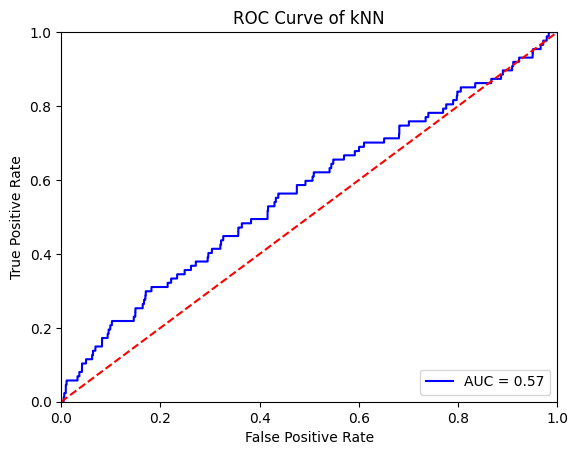

0.5666286456082152

In [88]:
rocres_curve(lr, ytest, xtest)

Text(0, 0.5, 'Cross-Validated Accuracy')

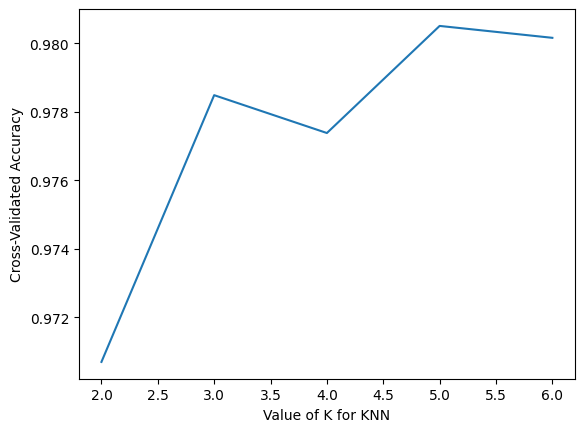

In [16]:
knn = KNeighborsClassifier()
knn.fit(xtrain, ytrain)
knn.score(xtrain, ytrain)

k_range = list(range(2,7))
parameters = {'n_neighbors': k_range}
grid = GridSearchCV(knn, parameters, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(xtrain, ytrain)

grid_mean_scores = grid.cv_results_['mean_test_score']

plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [82]:
knn.score(xtest, ytest)

0.9874549070391269

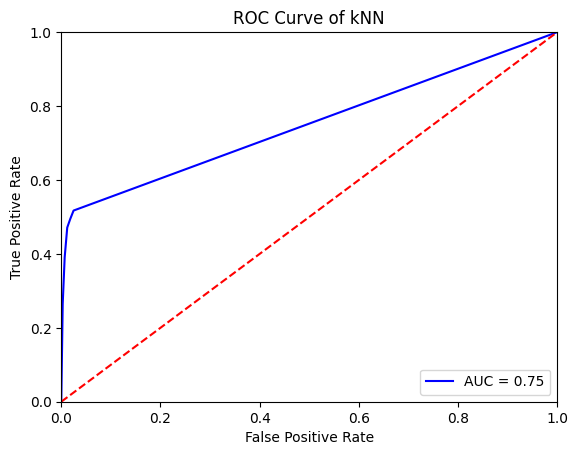

0.7500444665457922

In [85]:
rocres_curve(knn, ytest, xtest)